In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import load_model
import csv

import fnmatch
from scipy.io import wavfile
import scipy.io

In [2]:
data_dir = pathlib.Path(r"D:\magistracy\diplom\demo data")
for file in os.listdir(data_dir):
    if fnmatch.fnmatch(file,'*.wav'):
        filename = os.path.join(data_dir, file)
filename  

'D:\\magistracy\\diplom\\demo data\\guitar.wav'

C:\Users\belas\AppData\Local\Temp/ipykernel_11232/3565526111.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _ , waveform = wavfile.read(filename)


(0.0, 1311195.0)

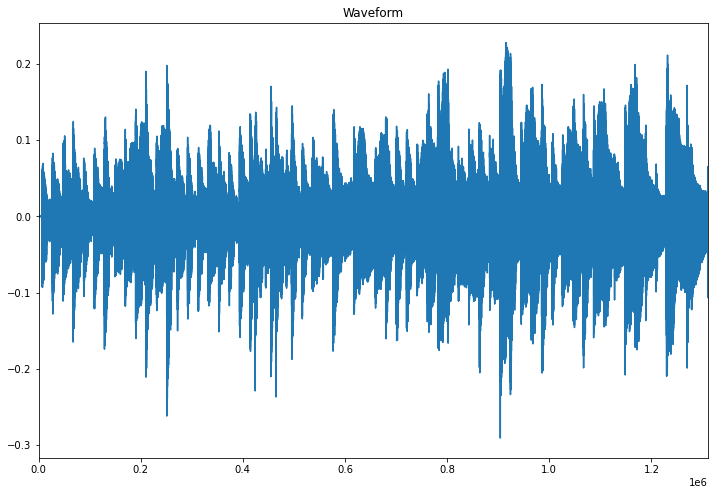

In [3]:
_ , waveform = wavfile.read(filename)
waveform = waveform[:,0]
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.plot(np.arange(waveform.shape[0]), waveform)
ax.set_title('Waveform')
ax.set_xlim([0, waveform.shape[0]])

In [4]:
model1 = load_model(r"D:\magistracy\diplom\model\model_stft_new.h5")
model2 = load_model(r"D:\magistracy\diplom\model\model_mfcc_new.h5")
model3 = load_model(r"D:\magistracy\diplom\model\model_fstft_new.h5")
model4 = load_model(r"D:\magistracy\diplom\model\model_mdct_new.h5")

In [5]:
n = np.array(['A','G#','G','F#','F','E','D#','D','C#','C','B','A#'])
print('Notes:', n)

Notes: ['A' 'G#' 'G' 'F#' 'F' 'E' 'D#' 'D' 'C#' 'C' 'B' 'A#']


In [6]:
# Загружаем триангулярные фильтры
with open('filters.npy', 'rb') as f:
    fbank = np.load(f)
    
fbank1 = tf.convert_to_tensor(fbank.T, dtype=tf.float32)   
print(fbank1.shape)

# Загружаем триангулярные фильтры
with open('filters_1.npy', 'rb') as f:
    fbank = np.load(f)
    
fbank2 = tf.convert_to_tensor(fbank.T, dtype=tf.float32)   
print(fbank2.shape)

(4097, 40)
(4097, 83)


In [7]:
def get_spectrogram_1(waveform):
    S = 2048
    spectrogram = tf.signal.stft(waveform, frame_length=8192, frame_step=S,pad_end=True)
    spectrogram = (tf.abs(spectrogram))**2
    spec_length = len(spectrogram)
    
    return spectrogram

def get_spectrogram_2(waveform):
    S = 2048
    NFFT = 8192
    waveform = tf.cast(waveform, tf.float32)
    spectrogram = tf.signal.stft(waveform, frame_length=NFFT, frame_step=S,pad_end=True)
    spectrogram = tf.abs(spectrogram)
    pow_frames = ((1.0 / NFFT) * ((spectrogram) ** 2))
    filter_banks = tf.tensordot(pow_frames, fbank1, axes = [[1], [0]])
    filter_banks = tf.where(filter_banks == 0, tf.keras.backend.epsilon(), filter_banks)  # Численная стабильность 
    # tf.keras.backend.epsilon() - машинный ноль)
    spectrogram = tf.math.log(filter_banks)  # Логарифмические энергии набора фильтров
    spectrogram = tf.signal.dct(spectrogram, type=2, axis=-1, norm='ortho')

    return spectrogram

def get_spectrogram_3(waveform):
    S = 1024
    NFFT = 8192
    waveform = tf.cast(waveform, tf.float32)
    spectrogram = tf.signal.stft(waveform, frame_length=NFFT, frame_step=S, fft_length=NFFT, pad_end=True)
    spectrogram = (tf.abs(spectrogram))**2
    spectrogram = tf.tensordot(spectrogram, fbank2, axes = [[1], [0]])

    return spectrogram

def get_spectrogram_4(waveform):
    NFFT = 8192
    waveform = tf.cast(waveform, tf.float32)
    spectrogram = tf.signal.mdct(waveform, frame_length=NFFT, pad_end=True)
    
    return spectrogram

In [8]:
def freq_distrib(freq):
    note = None
    
    y = np.log(440/freq)/np.log(2**(1/12))
    z = round(y)%12
    if z < 0:
        z += 12 
       
    n = {0: 'A',
         1: 'G#',
         2: 'G',
         3: 'F#',
         4: 'F',
         5: 'E',
         6: 'D#',
         7: 'D',
         8: 'C#',
         9: 'C',
         10: 'B',
         11: 'A#'}
    note = n[z]

    return z, note

def get_key(d, value):
    for k, v in d.items():
        if v == value:
            return k

notes = {0: 'A', 1: 'G#', 2: 'G',
         3: 'F#', 4: 'F', 5: 'E',
         6: 'D#', 7: 'D', 8: 'C#',
         9: 'C', 10: 'B', 11: 'A#'}

#### Настоящие ноты

In [9]:
for file in os.listdir(data_dir):
    if fnmatch.fnmatch(file,'*.csv'):
        filename_csv = os.path.join(data_dir, file)
filename_csv 

'D:\\magistracy\\diplom\\demo data\\guitar.csv'

In [10]:
time_start = []
time_end = []
pitch = []
notes_real = []
with open(filename_csv) as f:
    reader = csv.reader(f)
    for row in reader:
        time_start.append(row[0])
        time_end.append(row[1])
        pitch.append(row[2][0:len(row[2])])  
    time_start = list(map(float,time_start[1:len(time_start)+1]))
    time_end = list(map(float,time_end[1:len(time_end)+1]))
    pitch = list(map(float,pitch[1:len(pitch)+1]))
    for i in range(len(pitch)):
        z, note = freq_distrib(440*2**((pitch[i]-69)/12))
        notes_real.append((time_start[i],time_end[i],note))
                           
notes_real[0:10]

[(0.146, 0.613, 'C'),
 (0.616, 1.072, 'D'),
 (1.075, 1.536, 'E'),
 (1.54, 1.982, 'D'),
 (1.985, 2.461, 'C'),
 (2.465, 2.916, 'B'),
 (2.92, 3.402, 'C'),
 (3.407, 3.85, 'G'),
 (3.85, 4.297, 'A'),
 (4.305, 4.772, 'A')]

In [11]:
y_true = [x[2] for x in notes_real]
print(y_true)

['C', 'D', 'E', 'D', 'C', 'B', 'C', 'G', 'A', 'A', 'D', 'A', 'C', 'D', 'C', 'B', 'E', 'D', 'C', 'B', 'D', 'C', 'B', 'A', 'D', 'C', 'B', 'A', 'C', 'B', 'G#', 'E', 'B', 'A', 'A', 'B', 'C#', 'B', 'A', 'G#', 'A', 'E', 'F#', 'F#', 'B', 'F#', 'A', 'B', 'A', 'G#', 'C#', 'B', 'A', 'G#', 'B', 'A', 'G#', 'F#', 'A', 'G#', 'F', 'C#', 'G#', 'F#']


In [12]:
y_true = [get_key(notes,v) for v in y_true]
print(y_true)

[9, 7, 5, 7, 9, 10, 9, 2, 0, 0, 7, 0, 9, 7, 9, 10, 5, 7, 9, 10, 7, 9, 10, 0, 7, 9, 10, 0, 9, 10, 1, 5, 10, 0, 0, 10, 8, 10, 0, 1, 0, 5, 3, 3, 10, 3, 0, 10, 0, 1, 8, 10, 0, 1, 10, 0, 1, 3, 0, 1, 4, 8, 1, 3]


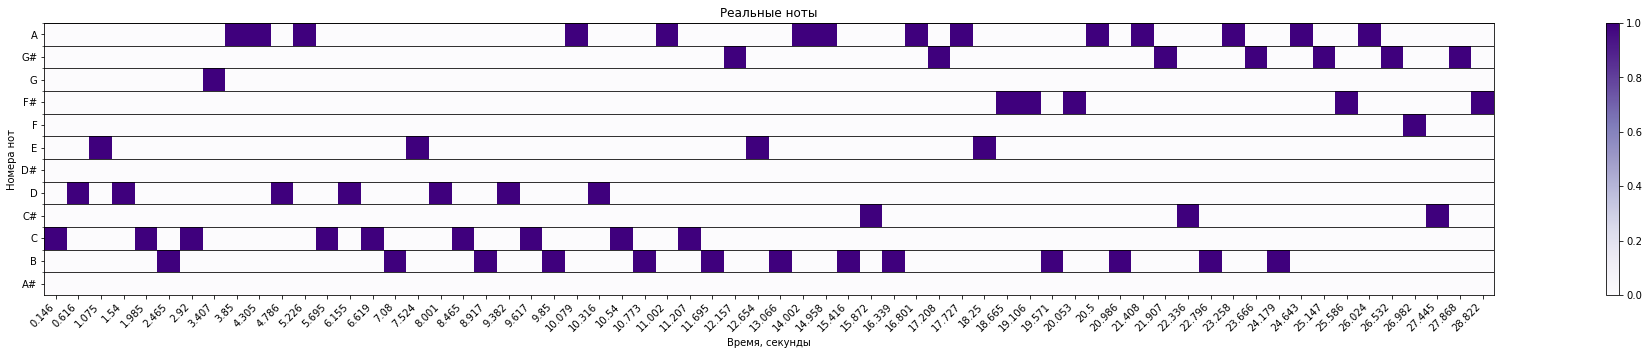

In [43]:
notes_true = tf.keras.utils.to_categorical(y_true, num_classes=12)
fig = plt.figure(figsize=(40, 5))
plt.imshow(notes_true.T, cmap='Purples', interpolation='nearest')
ax = plt.gca()
ax.set_yticks(np.arange(len(n)))
ax.set_yticks(np.arange(len(n)) - 0.5, minor=True)
ax.set_yticklabels(n)
times = np.array([notes_real[k][0] for k in range(len(notes_real))])
ax.set_xticks(np.arange(len(times)))
ax.set_xticklabels(times,rotation=45, ha='right')
plt.grid(True, which="minor", axis="y", color='k', linestyle="-")
plt.xlabel('Время, секунды')
plt.ylabel('Номера нот')
plt.title('Реальные ноты')
plt.colorbar()

In [168]:
notes_real[1][0]-notes_real[0][0]

0.47

In [171]:
t

array([ 0.146,  0.616,  1.075,  1.54 ,  1.985,  2.465,  2.92 ,  3.407,
        3.85 ,  4.305,  4.786,  5.226,  5.695,  6.155,  6.619,  7.08 ,
        7.524,  8.001,  8.465,  8.917,  9.382,  9.617,  9.85 , 10.079,
       10.316, 10.54 , 10.773, 11.002, 11.207, 11.695, 12.157, 12.654,
       13.066, 14.002, 14.958, 15.416, 15.872, 16.339, 16.801, 17.208,
       17.727, 18.25 , 18.665, 19.106, 19.571, 20.053, 20.5  , 20.986,
       21.408, 21.907, 22.336, 22.796, 23.258, 23.666, 24.179, 24.643,
       25.147, 25.586, 26.024, 26.532, 26.982, 27.445, 27.868, 28.822])

In [138]:
t = np.array([x[0] for x in notes_real])
m = min(np.diff(t))
q = np.round(np.diff(t)/m * 10).astype(int)
q = np.hstack((q, [q[-1]]))
z2 = np.repeat(notes_true, q, axis=0)
z2.shape

(1449, 12)

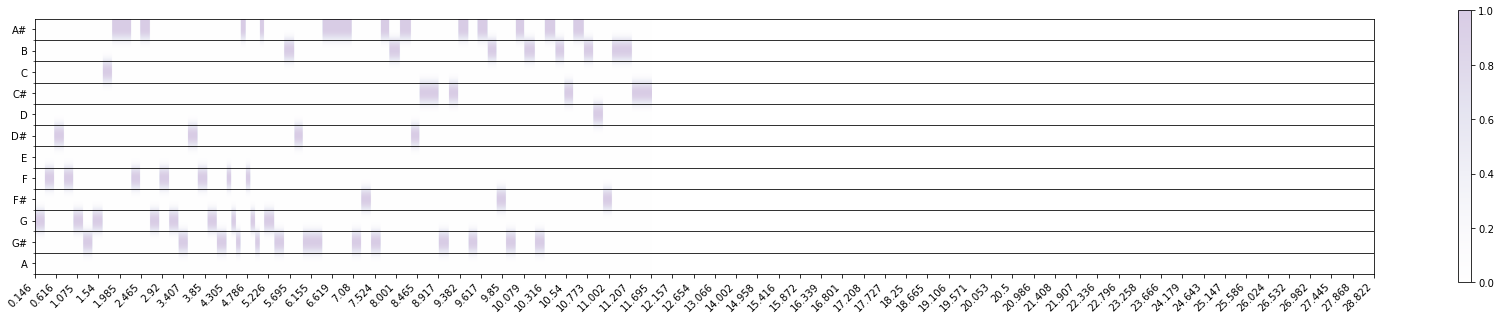

In [222]:
_, ax = plt.subplots(figsize=(30, 5))
extent = 0, 29, -0.5, len(notes_probability[0])-0.5
ax = plt.gca()
b = ax.imshow(z2.T, cmap='Purples', alpha=0.2, aspect=aspect, extent=extent)
plt.colorbar(b)

ax.set_yticks(np.arange(len(n)))
ax.set_yticks(np.arange(len(n))-0.5, minor=True)
ax.set_yticklabels(n)
ax.set_xticks(np.arange(len(t)))
ax.set_xticklabels(t,rotation=45, ha='right')
plt.grid(True, which="minor", axis="y", color='k', linestyle="-")

In [212]:
extent

(0, 29, -0.5, 11.5)

#### Модель STFT

In [366]:
spect = get_spectrogram_1(waveform)
spect.shape

TensorShape([641, 4097])

In [367]:
S = 2048 # шаг окна
M = 20 # количество спектрограмм
K = 8192 # размер окна

In [368]:
notes_probability = []
notes_all = []
times_st = []
times_e = []
for k in range(0,spect.shape[0]-M, int(M//2)):
    sp = spect[k:k+M]

    if M>sp.shape[0]:
        sp1 = sp
        for p in range(M-sp.shape[0]):
            spect_last = sp1[-1][:]
            spect_last = tf.expand_dims(spect_last, 0)
            sp1 = tf.concat([sp1, spect_last], 0)
        sp = sp1
    prediction = np.array(model1(tf.expand_dims(sp, 0)))
    notes_probability.extend(prediction)
    notes_all.append(n[np.argmax(prediction[0])])
    times_st.append(round(k * S/44100.0,3))
    times_e.append(round(((k + M) * S)/44100.0,3))
notes_probability = np.array(notes_probability)

In [369]:
notes

{0: 'A',
 1: 'G#',
 2: 'G',
 3: 'F#',
 4: 'F',
 5: 'E',
 6: 'D#',
 7: 'D',
 8: 'C#',
 9: 'C',
 10: 'B',
 11: 'A#'}

In [371]:
print(notes_all)

['E', 'E', 'E', 'E', 'F#', 'F#', 'F#', 'B', 'A', 'A', 'E', 'A', 'F#', 'E', 'F#', 'G', 'E', 'E', 'F#', 'F#', 'E', 'E', 'E', 'F#', 'F#', 'G', 'A#', 'F#', 'G', 'G', 'A', 'A', 'A', 'G', 'F', 'G', 'A', 'A#', 'A', 'G#', 'C', 'C', 'G', 'A', 'A', 'A', 'A', 'A#', 'F', 'G', 'A', 'A#', 'G', 'A', 'A#', 'A', 'A', 'A#', 'A#', 'A#', 'A#', 'A#', 'C']


In [353]:
aspect=notes_probability.shape[0]/notes_true.shape[0]
aspect

0.984375

In [354]:
t1 = [t[k] for k in range(0,len(t),2)]


In [361]:
z2.shape

(1449, 12)

In [363]:
notes_true

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.,

In [360]:
for k in range(z2.shape[0]):
    print(z2[:][k])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0.

In [359]:
for k in range(notes_probability.shape[0]):
    print(notes_probability[:][k])

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0.

Text(0.5, 1.0, 'Модель STFT')

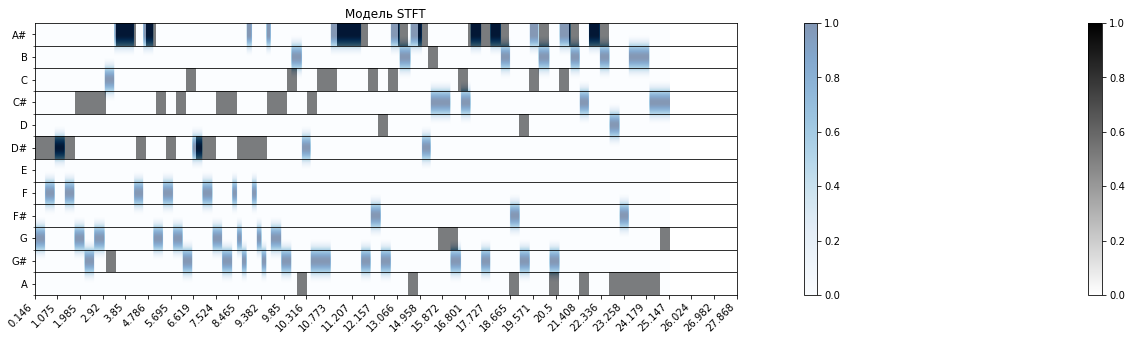

In [334]:
_, ax = plt.subplots(figsize=(30, 5))
extent = 0, 28, -0.5, len(notes_probability[0])-0.5
ax = plt.gca()
a = ax.imshow(notes_probability.T, cmap='binary', extent=extent)
plt.colorbar(a)
b = ax.imshow(z2.T, cmap='Blues', alpha=0.5, extent=extent) 
plt.colorbar(b)

ax.set_yticks(np.arange(len(n)))
ax.set_yticks(np.arange(len(n))-0.5, minor=True)
ax.set_yticklabels(n)
ax.set_xticks(np.arange(len(t1)))
ax.set_xticklabels(t1,rotation=45, ha='right')
plt.grid(True, which="minor", axis="y", color='k', linestyle="-")
plt.title('Модель STFT')

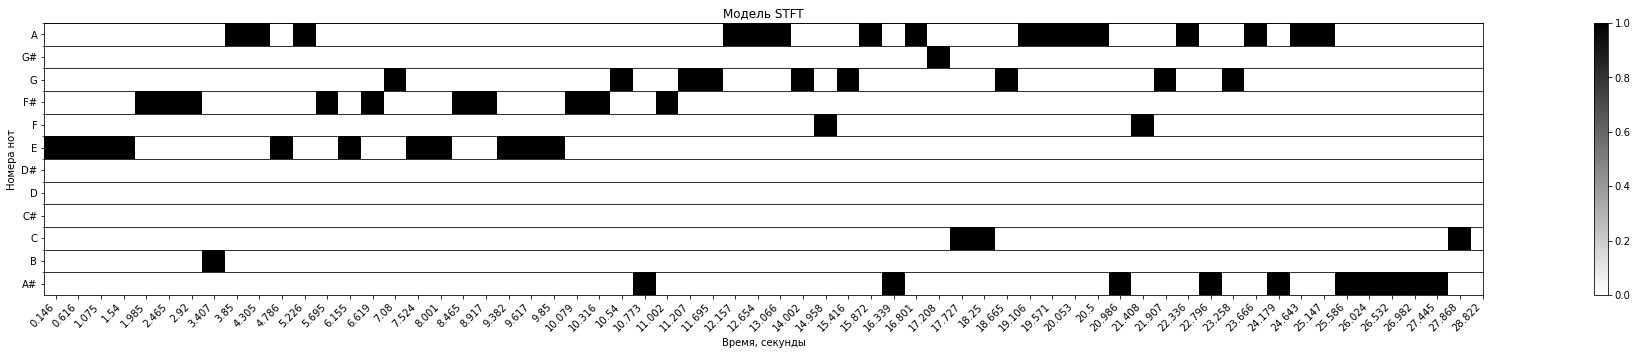

In [153]:
fig = plt.figure(figsize=(40, 5))
plt.imshow(notes_probability.T, cmap='binary', interpolation='nearest')
ax = plt.gca()
ax.set_yticks(np.arange(len(n)))
ax.set_yticks(np.arange(len(n)) - 0.5, minor=True)
ax.set_yticklabels(n)
#ax.set_xticks(np.arange(len(times_st)))
ax.set_xticks(np.arange(len(t)))
#ax.set_xticklabels(times_st,rotation=45, ha='right')
ax.set_xticklabels(t,rotation=45, ha='right')
plt.grid(True, which="minor", axis="y", color='k', linestyle="-")
plt.xlabel('Время, секунды')
plt.ylabel('Номера нот')
plt.title('Модель STFT')
plt.colorbar()

#### Модель MFCC

In [335]:
spect = get_spectrogram_2(waveform)
spect.shape

TensorShape([641, 40])

In [336]:
S = 1024 # шаг окна
M = 15 # количество спектрограмм
K = 8192 # размер окна

In [337]:
notes_probability = []
times_st = []
times_e = []
for k in range(0,spect.shape[0]-M, int(M//2)):
    sp = spect[k:k+M]

    if M>sp.shape[0]:
        sp1 = sp
        for p in range(M-sp.shape[0]):
            spect_last = sp1[-1][:]
            spect_last = tf.expand_dims(spect_last, 0)
            sp1 = tf.concat([sp1, spect_last], 0)
        sp = sp1
    prediction = np.array(model2(tf.expand_dims(sp, 0)))
    notes_probability.extend(prediction)
    times_st.append(round(k * S/44100.0,3))
    times_e.append(round(((k + M) * S)/44100.0,3))
notes_probability = np.array(notes_probability)

In [338]:
aspect=notes_probability.shape[0]/notes_true.shape[0]
aspect

1.40625

Text(0.5, 1.0, 'Модель MFCC')

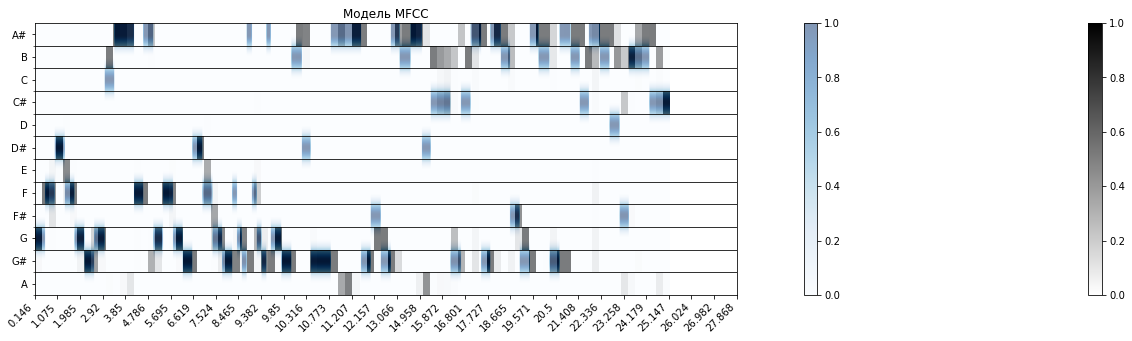

In [339]:
_, ax = plt.subplots(figsize=(30, 5))
extent = 0, 28, -0.5, len(notes_probability[0])-0.5
ax = plt.gca()
a = ax.imshow(notes_probability.T, cmap='binary', extent=extent)
plt.colorbar(a)
b = ax.imshow(z2.T, cmap='Blues', alpha=0.5, extent=extent) 
plt.colorbar(b)

ax.set_yticks(np.arange(len(n)))
ax.set_yticks(np.arange(len(n))-0.5, minor=True)
ax.set_yticklabels(n)
ax.set_xticks(np.arange(len(t1)))
ax.set_xticklabels(t1,rotation=45, ha='right')
plt.grid(True, which="minor", axis="y", color='k', linestyle="-")
plt.title('Модель MFCC')

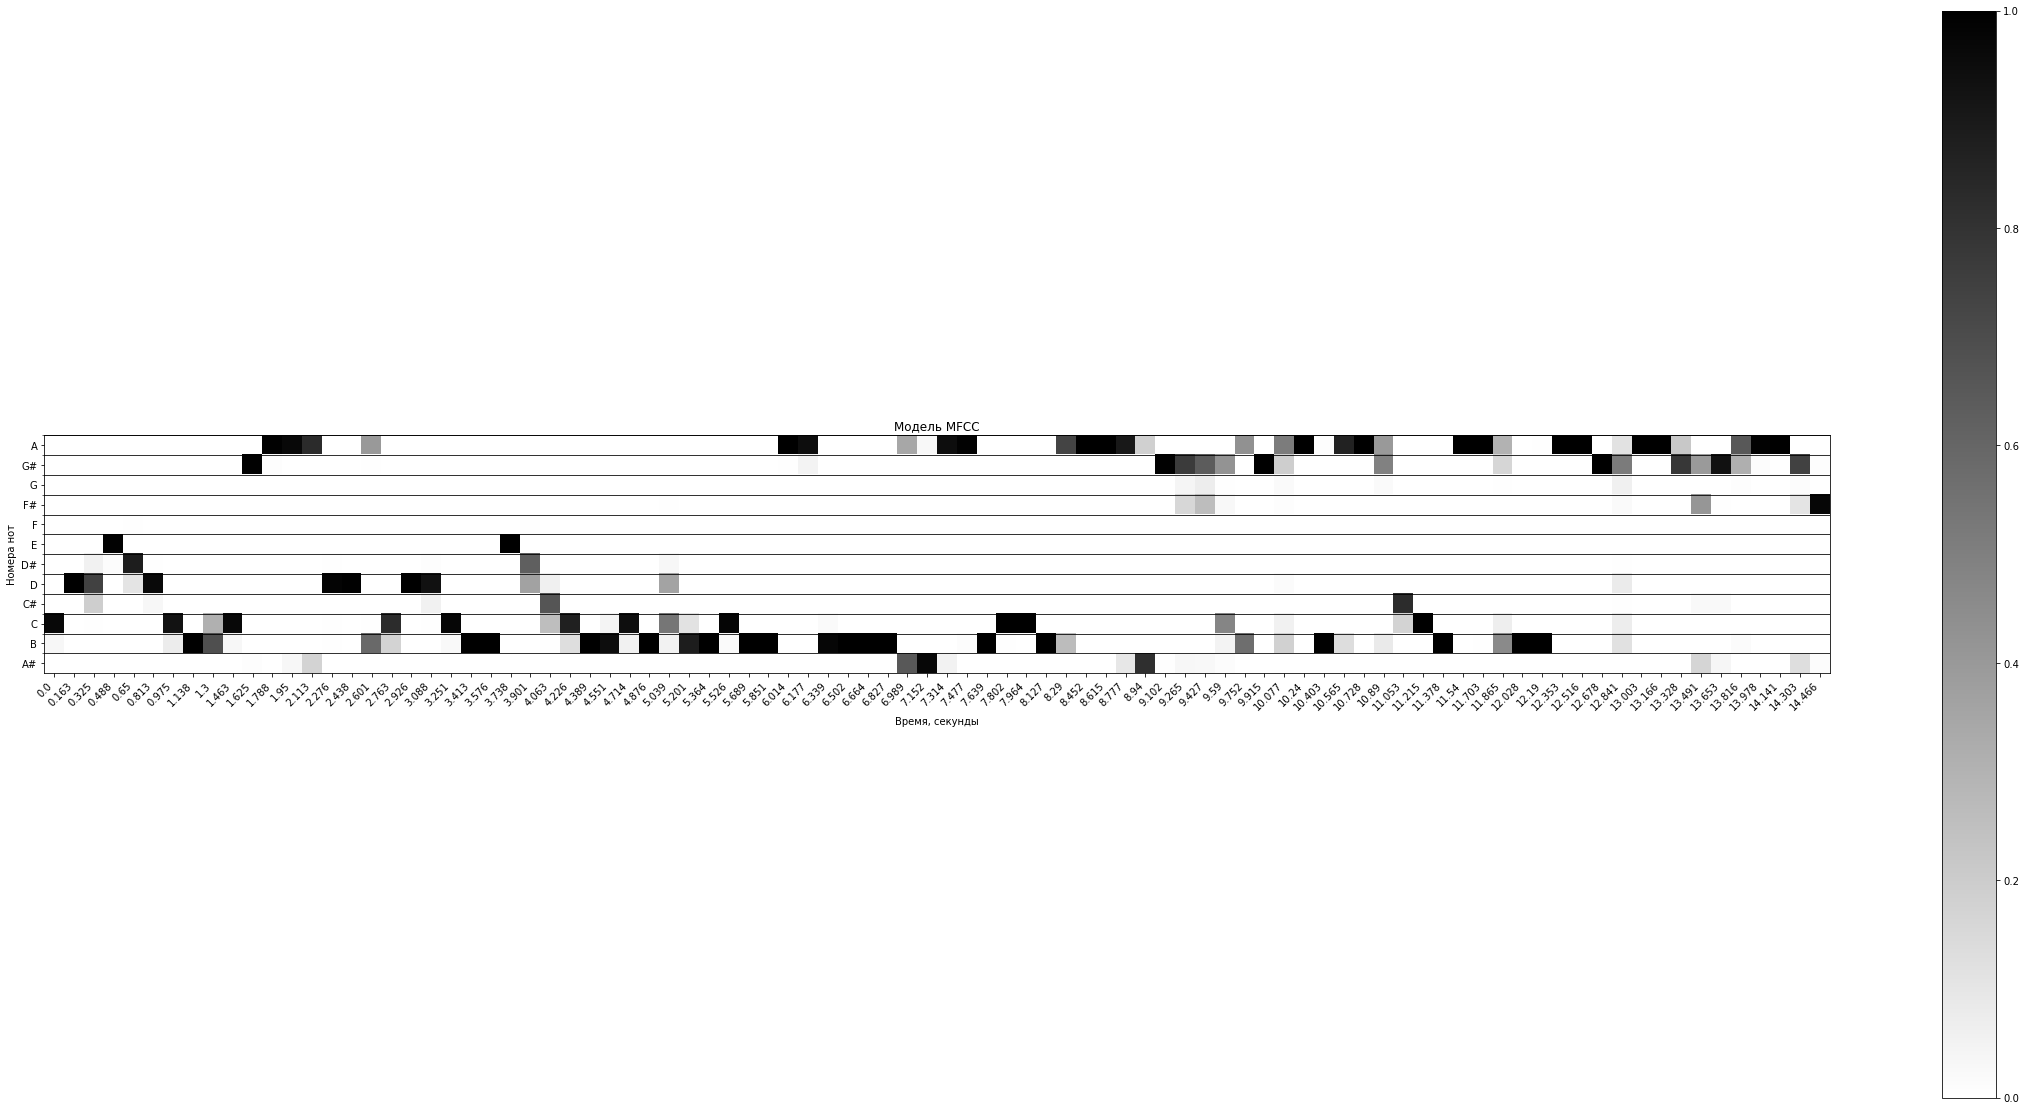

In [209]:
fig = plt.figure(figsize=(40, 20))
plt.imshow(notes_probability.T, cmap='binary', interpolation='nearest')
ax = plt.gca()
ax.set_yticks(np.arange(len(n)))
ax.set_yticks(np.arange(len(n)) - 0.5, minor=True)
ax.set_yticklabels(n)
ax.set_xticks(np.arange(len(times_st)))
ax.set_xticklabels(times_st,rotation=45, ha='right')
plt.grid(True, which="minor", axis="y", color='k', linestyle="-")
plt.xlabel('Время, секунды')
plt.ylabel('Номера нот')
plt.title('Модель MFCC')
plt.colorbar()

#### Модель fSTFT

In [340]:
spect = get_spectrogram_3(waveform)
spect.shape

TensorShape([1281, 83])

In [341]:
S = 2048 # шаг окна
M = 25 # количество спектрограмм
K = 8192 # размер окна

In [342]:
notes_probability = []
times_st = []
times_e = []
for k in range(0,spect.shape[0]-M, int(M//2)):
    sp = spect[k:k+M]

    if M>sp.shape[0]:
        sp1 = sp
        for p in range(M-sp.shape[0]):
            spect_last = sp1[-1][:]
            spect_last = tf.expand_dims(spect_last, 0)
            sp1 = tf.concat([sp1, spect_last], 0)
        sp = sp1
    prediction = np.array(model3(tf.expand_dims(sp, 0)))
    notes_probability.extend(prediction)
    times_st.append(round(k * S/44100.0,3))
    times_e.append(round(((k + M) * S)/44100.0,3))
notes_probability = np.array(notes_probability)

In [343]:
aspect=notes_probability.shape[0]/notes_true.shape[0]
aspect

1.640625

Text(0.5, 1.0, 'Модель fSTFT')

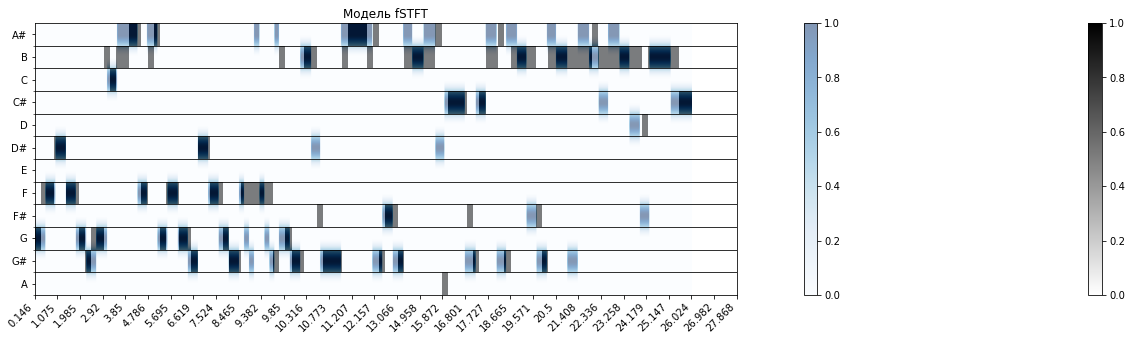

In [344]:
_, ax = plt.subplots(figsize=(30, 5))
extent = 0, 29, -0.5, len(notes_probability[0])-0.5
ax = plt.gca()
a = ax.imshow(notes_probability.T, cmap='binary', extent=extent)
plt.colorbar(a)
b = ax.imshow(z2.T, cmap='Blues', alpha=0.5, extent=extent) 
plt.colorbar(b)

ax.set_yticks(np.arange(len(n)))
ax.set_yticks(np.arange(len(n))-0.5, minor=True)
ax.set_yticklabels(n)
ax.set_xticks(np.arange(len(t1)))
ax.set_xticklabels(t1,rotation=45, ha='right')
plt.grid(True, which="minor", axis="y", color='k', linestyle="-")
plt.title('Модель fSTFT')

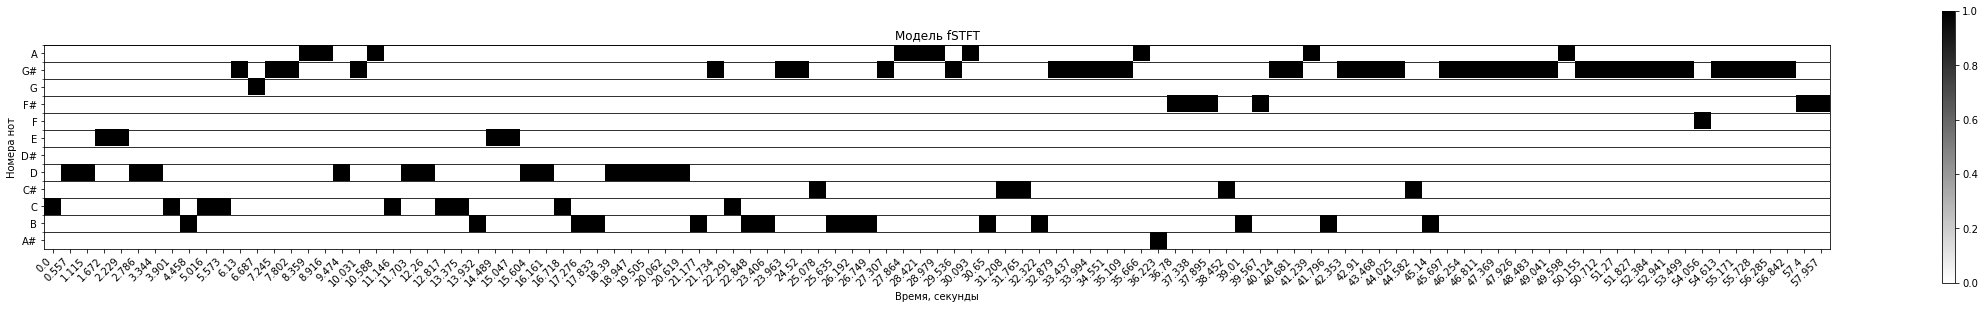

In [213]:
fig = plt.figure(figsize=(40, 5))
plt.imshow(notes_probability.T, cmap='binary', interpolation='nearest')
ax = plt.gca()
ax.set_yticks(np.arange(len(n)))
ax.set_yticks(np.arange(len(n)) - 0.5, minor=True)
ax.set_yticklabels(n)
ax.set_xticks(np.arange(len(times_st)))
ax.set_xticklabels(times_st,rotation=45, ha='right')
plt.grid(True, which="minor", axis="y", color='k', linestyle="-")
plt.xlabel('Время, секунды')
plt.ylabel('Номера нот')
plt.title('Модель fSTFT')
plt.colorbar()

#### Модель mDCT

In [345]:
spect = get_spectrogram_4(waveform)
spect.shape

TensorShape([321, 4096])

In [346]:
M = 3 # количество спектрограмм
K = 8192 # размер окна
S = int(K/2) # шаг окна по умолчанию

In [347]:
notes_probability = []
times_st = []
times_e = []
for k in range(0,spect.shape[0]-M, int(M//2)):
    sp = spect[k:k+M]

    if M>sp.shape[0]:
        sp1 = sp
        for p in range(M-sp.shape[0]):
            spect_last = sp1[-1][:]
            spect_last = tf.expand_dims(spect_last, 0)
            sp1 = tf.concat([sp1, spect_last], 0)
        sp = sp1
    prediction = np.array(model4(tf.expand_dims(sp, 0)))
    notes_probability.extend(prediction)
    times_st.append(round(k * S/44100.0,3))
    times_e.append(round(((k + M) * S)/44100.0,3))
notes_probability = np.array(notes_probability)

In [348]:
aspect=notes_probability.shape[0]/notes_true.shape[0]
aspect

4.96875

Text(0.5, 1.0, 'Модель mDCT')

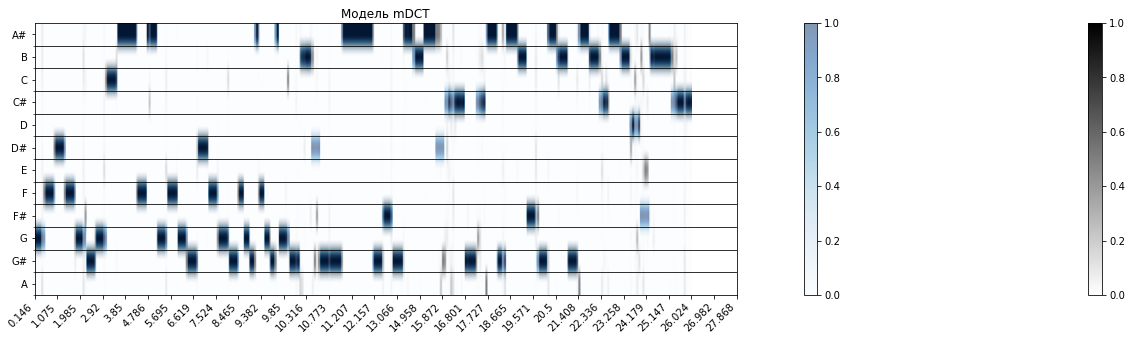

In [349]:
_, ax = plt.subplots(figsize=(30, 5))
extent = 0, 29, -0.5, len(notes_probability[0])-0.5
ax = plt.gca()
a = ax.imshow(notes_probability.T, cmap='binary', extent=extent)
plt.colorbar(a)
b = ax.imshow(z2.T, cmap='Blues', alpha=0.5, extent=extent) 
plt.colorbar(b)

ax.set_yticks(np.arange(len(n)))
ax.set_yticks(np.arange(len(n))-0.5, minor=True)
ax.set_yticklabels(n)
ax.set_xticks(np.arange(len(t1)))
ax.set_xticklabels(t1,rotation=45, ha='right')
plt.grid(True, which="minor", axis="y", color='k', linestyle="-")
plt.title('Модель mDCT')

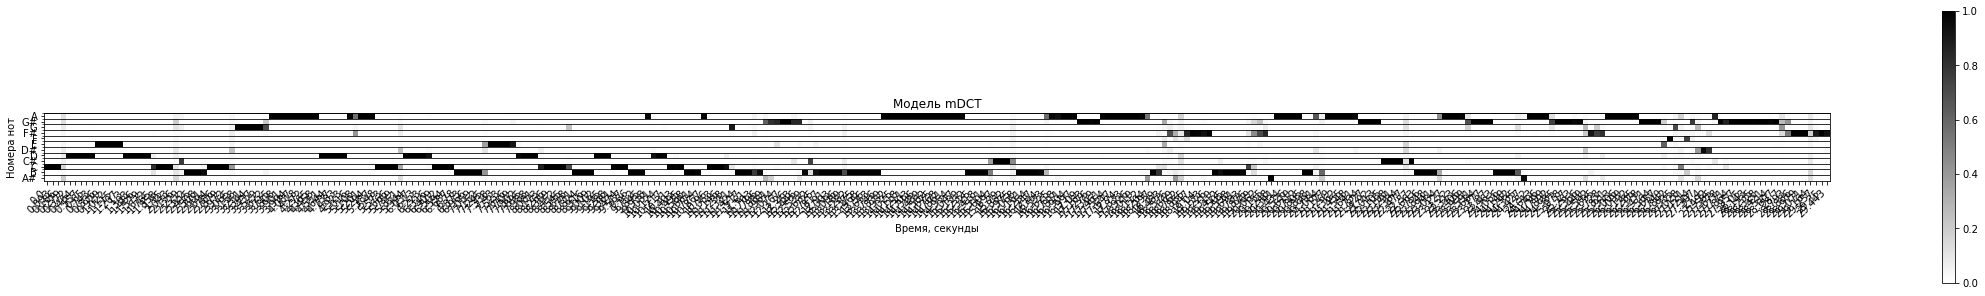

In [217]:
fig = plt.figure(figsize=(40, 5))
plt.imshow(notes_probability.T, cmap='binary', interpolation='nearest')
ax = plt.gca()
ax.set_yticks(np.arange(len(n)))
ax.set_yticks(np.arange(len(n)) - 0.5, minor=True)
ax.set_yticklabels(n)
ax.set_xticks(np.arange(len(times_st)))
ax.set_xticklabels(times_st,rotation=45, ha='right')
plt.grid(True, which="minor", axis="y", color='k', linestyle="-")
plt.xlabel('Время, секунды')
plt.ylabel('Номера нот')
plt.title('Модель mDCT')
plt.colorbar()